In [0]:
# load file paths and constants

%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)


# file paths
PATH = "/content/drive/My Drive/"
file_path = "/content/drive/My Drive/book_cover_data/title30/title30cat_2.zip"
csv_path = "/content/drive/My Drive/book_cover_data/title30/book30short.csv"
cover_path = "/content/224x224/"

# constants
val_ratio = 0.1
test_ratio = 0.1
BUFFER_SIZE = 1000
BATCH_SIZE = 32
steps_train = (57000*0.8) // BATCH_SIZE
steps_val = (57000*0.1) // BATCH_SIZE
steps_test = (57000*0.1) // BATCH_SIZE
IMG_DIM = (224, 224, 3)
outdim_size = 30
vocab_size = 17997

# tfrecord file name for train, test and val
tfrecord_path = ["train_data.tfrecord", "val_data.tfrecord", "test_data.tfrecord"]

# unzip files
def unzip_data(file_path):
  from zipfile import ZipFile
  with ZipFile(file_path, "r") as zip:
    zip.extractall()
    return "Data has been extracted"

unzip_data(file_path)

2.2.0


In [0]:
# load helper function for tensorflow data pipleline

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# helper functions for writing tfrecord data
def load_csv():
    df = pd.read_csv(csv_path, header = 0, index_col = 0, encoding='latin1')

    # split the data into train, validation and test
    train_data, val_data = train_test_split(df, test_size=(test_ratio+val_ratio), random_state=21)
    val_data, test_data = train_test_split(val_data, test_size=test_ratio/(test_ratio+val_ratio), random_state=21)

    return train_data, val_data, test_data


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# functions for process texts
def get_token(texts, word_freq=5):
  words = texts.str.split(expand=True).stack().value_counts()
  words = pd.DataFrame(words, columns=["freq"])
  vocab_size = len(words[words.freq > word_freq])
  token = Tokenizer(num_words=vocab_size)
  token.fit_on_texts(texts)
  return token, vocab_size

def get_text_sequence(text, token, max_len=100):
  sequences = token.texts_to_sequences([text])
  return pad_sequences(sequences,maxlen=max_len).reshape(-1)

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def make_example(image_string, text_sequence, label, keras_hub=False):
    if keras_hub:
      text_seq = _bytes_feature(text_sequence.encode())
    else:
      text_seq = tf.train.Feature(int64_list=tf.train.Int64List(value=text_sequence))

    feature = {
        'image_string': _bytes_feature(image_string),
        'text_sequence': text_seq,
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecord(data, token, tfrecord_path, keras_hub=False):
    with tf.io.TFRecordWriter(tfrecord_path) as writer:
        for _,row in data.iterrows():
            img_file = cover_path+row["file"]
            text_sequence = row["text"] if keras_hub else get_text_sequence(row["text"], token)
            label = row["cat_id"]
            image_string = open(img_file, 'rb').read()
            example = make_example(image_string, text_sequence, label, keras_hub)  
            writer.write(example.SerializeToString()) 

# healper functions for reading tfrecord data 
feature_description = {
    'image_string': tf.io.FixedLenFeature([], tf.string),
    'text_sequence': tf.io.FixedLenFeature([100], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

feature_description_hub = {
    'image_string': tf.io.FixedLenFeature([], tf.string),
    'text_sequence': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

def parse_image(image):
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [IMG_DIM[0], IMG_DIM[1]])
  return image


def parser(proto):
    parsed_features = tf.io.parse_single_example(proto, feature_description)
    image_string = parsed_features['image_string']
    image_string = parse_image(image_string)
    text_sequence = parsed_features['text_sequence']
    label = parsed_features['label']
    return (image_string, text_sequence), label

def parser_hub(proto):
    parsed_features = tf.io.parse_single_example(proto, feature_description_hub)
    image_string = parsed_features['image_string']
    image_string = parse_image(image_string)
    text_sequence = parsed_features['text_sequence']
    label = parsed_features['label']
    return (image_string, text_sequence), label

def get_dataset(tfrecord_path, keras_hub=False, batch_size=BATCH_SIZE):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    if keras_hub:
        dataset = dataset.map(parser_hub, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    else:
        dataset = dataset.map(parser, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    #dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

    
def load_cat(newdata, tfrecord_path = "new.tfrecord"):
    data = load_csv()
    token, _ = get_token(data[0].text)
    
    dataset = []
    for i in range(outdim_size):
        tfrecord_path = "test_cat"+str(i)+".tfrecord"
        write_tfrecord(newdata[i], token, tfrecord_path)
        dataset.append(get_dataset(tfrecord_path))

    return dataset

def load_data(first_time=True, keras_hub=False):
    if first_time:
        data = load_csv()
        token, _ = get_token(data[0].text)
        for i in range(3):
           write_tfrecord(data[i], token, tfrecord_path[i], keras_hub)

    # load the dataset    
    dataset = []   
    for i in range(3):
        data = get_dataset(tfrecord_path[i], keras_hub)
        dataset.append(data)
    return dataset


In [0]:
train_data, val_data, test_data = load_data(True, True)

In [0]:
# TRAIN MODEL
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt


def train_model(model, epoch_num):
  
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=1)
    checkpointer = ModelCheckpoint(filepath="temp_weights.h5", verbose=1, save_best_only=True, save_weights_only=True)
  
    history = model.fit(train_data.repeat(),
                        steps_per_epoch = steps_train,
                        epochs = epoch_num,
                        validation_data= val_data.repeat(),
                        validation_steps = steps_val,
                        use_multiprocessing=True,
                        callbacks=[checkpointer, earlystop])


    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    model.load_weights("temp_weights.h5")

    results = model.evaluate(test_data, use_multiprocessing=True, verbose=1)

    print('loss on test data: ', results)

    results = model.evaluate(val_data, use_multiprocessing=True, verbose=1)

    print('loss on validation data: ', results)
    return model

DCCA helper function

In [0]:
# Loss function 
# the main dcca implementation was orignially done by Vahid Noroozi
# https://github.com/VahidooX/DeepCCA


def cca_loss(outdim_size, use_all_singular_values):
    """
    The main loss function (inner_cca_objective) is wrapped in this function due to
    the constraints imposed by Keras on objective functions
    """

    def inner_cca_objective(y_true, y_pred):
        """
        It is the loss function of CCA as introduced in the original paper. There can be other formulations.
        It is implemented on Tensorflow based on github@VahidooX's cca loss on Theano.
        y_true is just ignored
        """

        r1 = 1e-2
        r2 = 1e-2
        eps = 1e-10
        o1 = o2 = int(y_pred.shape[1] // 2)

        # unpack (separate) the output of networks for view 1 and view 2
        H1 = tf.transpose(y_pred[:, 0:o1])
        H2 = tf.transpose(y_pred[:, o1:o1 + o2])

        m = tf.shape(H1)[1]

        H1bar = H1 - tf.cast(tf.divide(1, m), tf.float32) * tf.matmul(H1, tf.ones([m, m]))
        H2bar = H2 - tf.cast(tf.divide(1, m), tf.float32) * tf.matmul(H2, tf.ones([m, m]))

        SigmaHat12 = tf.cast(tf.divide(1, m - 1), tf.float32) * tf.matmul(H1bar, H2bar, transpose_b=True)  # [dim, dim]
        SigmaHat11 = tf.cast(tf.divide(1, m - 1), tf.float32) * tf.matmul(H1bar, H1bar, transpose_b=True) + r1 * tf.eye(
            o1)
        SigmaHat22 = tf.cast(tf.divide(1, m - 1), tf.float32) * tf.matmul(H2bar, H2bar, transpose_b=True) + r2 * tf.eye(
            o2)
        
        # Calculating the root inverse of covariance matrices by using eigen decomposition
        [D1, V1] = tf.linalg.eigh(SigmaHat11)
        [D2, V2] = tf.linalg.eigh(SigmaHat22)  # Added to increase stability

        posInd1 = tf.where(tf.greater(D1, eps))
        D1 = tf.gather_nd(D1, posInd1)  # get eigen values that are larger than eps
        V1 = tf.transpose(tf.nn.embedding_lookup(tf.transpose(V1), tf.squeeze(posInd1)))
        
        posInd2 = tf.where(tf.greater(D2, eps))
        D2 = tf.gather_nd(D2, posInd2)
        V2 = tf.transpose(tf.nn.embedding_lookup(tf.transpose(V2), tf.squeeze(posInd2)))

        SigmaHat11RootInv = tf.matmul(tf.matmul(V1, tf.linalg.diag(D1 ** -0.5)), V1, transpose_b=True)  # [dim, dim]
        SigmaHat22RootInv = tf.matmul(tf.matmul(V2, tf.linalg.diag(D2 ** -0.5)), V2, transpose_b=True)
        
        Tval = tf.matmul(tf.matmul(SigmaHat11RootInv, SigmaHat12), SigmaHat22RootInv)

        if use_all_singular_values:
            corr = tf.sqrt(tf.linalg.trace(tf.matmul(Tval, Tval, transpose_a=True)))
        else:
            [U, V] = tf.linalg.eigh(tf.matmul(Tval, Tval, transpose_a=True))
            U = tf.gather_nd(U, tf.where(tf.greater(U, eps)))
            kk = tf.reshape(tf.cast(tf.shape(U), tf.int32), [])
            K = tf.minimum(kk, outdim_size)
            w, _ = tf.nn.top_k(U, k=K)
            corr = tf.reduce_sum(tf.sqrt(w))

        return -corr

    return inner_cca_objective

In [0]:
# linear_cca.py
import numpy
def linear_cca(H1, H2, outdim_size):
    """
    An implementation of linear CCA
    # Arguments:
        H1 and H2: the matrices containing the data for view 1 and view 2. Each row is a sample.
        outdim_size: specifies the number of new features
    # Returns
        A and B: the linear transformation matrices 
        mean1 and mean2: the means of data for both views
    """
    r1 = 1e-5
    r2 = 1e-5

    m = H1.shape[0]
    o = H1.shape[1]

    mean1 = numpy.mean(H1, axis=0)
    mean2 = numpy.mean(H2, axis=0)
    H1bar = H1 - numpy.tile(mean1, (m, 1))
    H2bar = H2 - numpy.tile(mean2, (m, 1))

    SigmaHat12 = (1.0 / (m - 1)) * numpy.dot(H1bar.T, H2bar)
    SigmaHat11 = (1.0 / (m - 1)) * numpy.dot(H1bar.T, H1bar) + r1 * numpy.identity(o)
    SigmaHat22 = (1.0 / (m - 1)) * numpy.dot(H2bar.T, H2bar) + r2 * numpy.identity(o)

    [D1, V1] = numpy.linalg.eigh(SigmaHat11)
    [D2, V2] = numpy.linalg.eigh(SigmaHat22)
    SigmaHat11RootInv = numpy.dot(numpy.dot(V1, numpy.diag(D1 ** -0.5)), V1.T)
    SigmaHat22RootInv = numpy.dot(numpy.dot(V2, numpy.diag(D2 ** -0.5)), V2.T)

    Tval = numpy.dot(numpy.dot(SigmaHat11RootInv, SigmaHat12), SigmaHat22RootInv)

    [U, D, V] = numpy.linalg.svd(Tval)
    V = V.T
    A = numpy.dot(SigmaHat11RootInv, U[:, 0:outdim_size])
    B = numpy.dot(SigmaHat22RootInv, V[:, 0:outdim_size])
    D = D[0:outdim_size]

    return A, B, mean1, mean2

# final classifier
from sklearn import svm
from sklearn.metrics import accuracy_score
def classify(data, classifier, alpha = 0.5,  feature_clf="weighted"):
    """
    trains  on the data
    input C specifies the penalty factor of SVM
    """
    if feature_clf=="text":
      _, train_data, train_label = data[0]
      _, valid_data,valid_label = data[1]
      _, test_data, test_label = data[2]
    elif feature_clf=="img":
      train_data, _, train_label = data[0]
      valid_data, _, valid_label = data[1]
      test_data, _, test_label = data[2]
    elif feature_clf=="merged":
      train_data1, train_data2, train_label = data[0]
      valid_data1, valid_data2, valid_label = data[1]
      test_data1, test_data2, test_label = data[2] 

      train_data = np.concatenate((train_data1,train_data2),axis=1)
      valid_data = np.concatenate((valid_data1,valid_data2),axis=1)
      test_data = np.concatenate((test_data1,test_data2),axis=1)      
    else:
      train_data1, train_data2, train_label = data[0]
      valid_data1, valid_data2, valid_label = data[1]
      test_data1, test_data2, test_label = data[2]  

      train_data = alpha*train_data1 + (1-alpha)*train_data2
      valid_data = alpha*valid_data1 + (1-alpha)*valid_data2
      test_data = alpha*test_data1 + (1-alpha)*test_data2

    print('training classifier...')
    classifier.fit(train_data, train_label.ravel())

    p = classifier.predict(test_data)
    test_acc = accuracy_score(test_label, p)
    probs = classifier.predict_proba(test_data)
    test_top3 = topk_accuracy(test_label, probs)

    p = classifier.predict(valid_data)
    valid_acc = accuracy_score(valid_label, p)
    probs = classifier.predict_proba(valid_data)
    valid_top3 = topk_accuracy(valid_label, probs)

    return [test_acc, test_top3, valid_acc, valid_top3]
    

def topk_accuracy(truths, preds, n=3):
    best_n = np.argsort(preds, axis=1)[:,-n:]
    successes = 0
    for i in range(truths.shape[0]):
      if truths[i] in best_n[i,:]:
        successes += 1
    return float(successes)/truths.shape[0]

def get_prediction(model, data):
    result = []
    labels = []
    for _, elements in enumerate(data):  
        new_res = model.predict_on_batch(elements[0])
        result[0:0] = new_res
        labels[0:0] = elements[1].numpy()
    result = np.asarray(result)
    labels = np.asarray(labels, dtype=np.int32)
    return result, labels


def tt_model(model, apply_linear_cca, final_prediction=False):
    """produce the new features by using the trained model
    # Arguments
        model: the trained model
        data1 and data2: the train, validation, and test data for view 1 and view 2 respectively.
            Data should be packed like
            ((X for train, Y for train), (X for validation, Y for validation), (X for test, Y for test))
        outdim_size: dimension of new features
        apply_linear_cca: if to apply linear CCA on the new features
    # Returns
        new features packed like
            ((new X for train - view 1, new X for train - view 2, Y for train),
            (new X for validation - view 1, new X for validation - view 2, Y for validation),
            (new X for test - view 1, new X for test - view 2, Y for test))
    """

    # producing the new features
    if final_prediction:
      data = [final_prediction]
    else:
      data = [train_data, val_data, test_data]
    new_data = []
    for k in range(len(data)):
        pred_out, labels = get_prediction(model, data[k])
        r = int(pred_out.shape[1] / 2)
        new_data.append([pred_out[:, :r], pred_out[:, r:], labels])

    # based on the DCCA paper, a linear CCA should be applied on the output of the networks because
    # the loss function actually estimates the correlation when a linear CCA is applied to the output
    # of the networks
    # however it does not improve the performance significantly
    if apply_linear_cca:
        w = [None, None]
        m = [None, None]
        print("Linear CCA started!")
        w[0], w[1], m[0], m[1] = linear_cca(new_data[0][0], new_data[0][1], outdim_size)
        print("Linear CCA ended!")

        # Something done in the original MATLAB implementation of DCCA, do not know exactly why;)
        # it did not affect the performance significantly on the noisy MNIST dataset
        # s = np.sign(w[0][0,:])
        # s = s.reshape([1, -1]).repeat(w[0].shape[0], axis=0)
        # w[0] = w[0] * s
        # w[1] = w[1] * s
        ###

        for k in range(len(data)):
            data_num = len(new_data[k][0])
            for v in range(2):
                new_data[k][v] -= m[v].reshape([1, -1]).repeat(data_num, axis=0)
                new_data[k][v] = np.dot(new_data[k][v], w[v])

    return new_data

In [0]:
# DCCA model
from tensorflow.keras import layers, models, optimizers, losses, regularizers, metrics, applications

def create_model_dcca(img_base, text_base):
    """
    builds the whole model
    the structure of each sub-network is defined
    """
    view1_model = build_hubnet_image(img_base)
    view2_model = build_hubnet_text(text_base)
    
    model_concat = layers.concatenate([view1_model.output, view2_model.output], axis=-1)
    model = models.Model(inputs=[view1_model.input, view2_model.input], outputs=model_concat)

    model_optimizer = optimizers.RMSprop()
    model.compile(loss=cca_loss(outdim_size, use_all_singular_values), optimizer=model_optimizer)

    return model


def build_hubnet_image(img_base):
    model = models.Sequential()
    model.add(layers.Input(IMG_DIM))
    model.add(img_base)
    model.add(layers.Dense(outdim_size, activation="relu"))
    return model

def build_hubnet_text(text_base):
    model = models.Sequential()
    model.add(text_base)
    model.add(layers.Dense(outdim_size, activation="relu"))
    return model

In [0]:
import tensorflow_hub as hub
img_base = "https://tfhub.dev/tensorflow/resnet_50/feature_vector/1"
img_base = hub.KerasLayer(img_base, input_shape=[])
text_base = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
text_base = hub.KerasLayer(text_base, input_shape=[], dtype=tf.string)

In [0]:
use_all_singular_values = False
model = create_model_dcca(img_base, text_base)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
keras_layer_1_input (InputLayer [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 2048)         23561152    input_1[0][0]                    
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      (None, 512)          147354880   keras_layer_1_input[0][0]        
______________________________________________________________________________________________

In [0]:
!cp "/content/drive/My Drive/Final/BC Weighted/temp_weights.h5" "dcca_temp_weights.h5"

Epoch 1/5
1425/1425 [==============================] - ETA: 0s - loss: -26.9541
Epoch 00001: val_loss improved from inf to -26.99375, saving model to temp_weights.h5
1425/1425 [==============================] - 187s 131ms/step - loss: -26.9541 - val_loss: -26.9938
Epoch 2/5
1425/1425 [==============================] - ETA: 0s - loss: -27.1387
Epoch 00002: val_loss improved from -26.99375 to -27.19561, saving model to temp_weights.h5
1425/1425 [==============================] - 187s 131ms/step - loss: -27.1387 - val_loss: -27.1956
Epoch 3/5
1425/1425 [==============================] - ETA: 0s - loss: -27.2856
Epoch 00003: val_loss improved from -27.19561 to -27.34057, saving model to temp_weights.h5
1425/1425 [==============================] - 187s 131ms/step - loss: -27.2856 - val_loss: -27.3406
Epoch 4/5
1425/1425 [==============================] - ETA: 0s - loss: -27.3702
Epoch 00004: val_loss improved from -27.34057 to -27.40355, saving model to temp_weights.h5
1425/1425 [==========

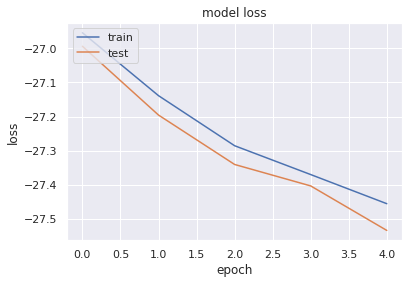

178/178 [==============================] - 19s 109ms/step - loss: -27.5132
loss on test data:  -27.513158798217773
178/178 [==============================] - 19s 109ms/step - loss: -27.4920
loss on validation data:  -27.492033004760742


In [0]:
train_model(model, 5)

In [0]:
model.load_weights("dcca_temp_weights.h5")

In [0]:
apply_linear_cca = True
new_data = tt_model(model, apply_linear_cca)

Linear CCA started!
Linear CCA ended!


In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [0]:
clf = SVC(C=2, gamma="auto", shrinking=False, probability=True)
[test_acc, test_top3, valid_acc, valid_top3] = classify(new_data, clf, feature_clf="merged")
print("Validation- Accuracy: ", valid_acc * 100.0, ", Top3 Accuracy: ", valid_top3 * 100.0)
print("Test- Accuracy: ", test_acc * 100.0, ", Top3 Accuracy: ", test_top3 * 100.0)

training classifier...
Validation- Accuracy:  48.03370786516854 , Top3 Accuracy:  71.73455056179775
Test- Accuracy:  48.929073033707866 , Top3 Accuracy:  72.27879213483146


In [0]:
import joblib
!cp "/content/drive/My Drive/Final/BC Weighted/dcca_svm.sav" "dcca_svm.sav" 
classifier = joblib.load("dcca_svm.sav")

# **Visualization**

In [0]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
tedf = pd.read_csv(csv_path, header = 0, index_col = 0, encoding='latin1')
cat_tup = tedf.groupby(["cat_id", "cat"]).count().index.values
cat_dict=dict() 
for cat_id,cat in cat_tup: 
    cat_dict[cat_id] = cat
print(cat_dict)

{0: 'Arts & Photography', 1: 'Biographies & Memoirs', 2: 'Business & Money', 3: 'Calendars', 4: "Children's Books", 5: 'Comics & Graphic Novels', 6: 'Computers & Technology', 7: 'Cookbooks, Food & Wine', 8: 'Crafts, Hobbies & Home', 9: 'Christian Books & Bibles', 10: 'Engineering & Transportation', 11: 'Health, Fitness & Dieting', 12: 'History', 13: 'Humor & Entertainment', 14: 'Law', 15: 'Literature & Fiction', 16: 'Medical Books', 17: 'Mystery, Thriller & Suspense', 18: 'Parenting & Relationships', 19: 'Politics & Social Sciences', 20: 'Reference', 21: 'Religion & Spirituality', 22: 'Romance', 23: 'Science & Math', 24: 'Science Fiction & Fantasy', 25: 'Self-Help', 26: 'Sports & Outdoors', 27: 'Teen & Young Adult', 28: 'Test Preparation', 29: 'Travel'}


In [0]:
X1 = new_data[0][0]
X2 = new_data[0][1]
y = new_data[0][2]
X = np.concatenate((X1,X2),axis=1) 
X = (X - X.min())/(X.max() - X.min())

In [0]:
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = [cat_dict[i] for i in y]
df['genre'] = df['y'].apply(lambda i: str(i))

In [0]:
# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

In [0]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.02633257 0.02359978 0.02283402]


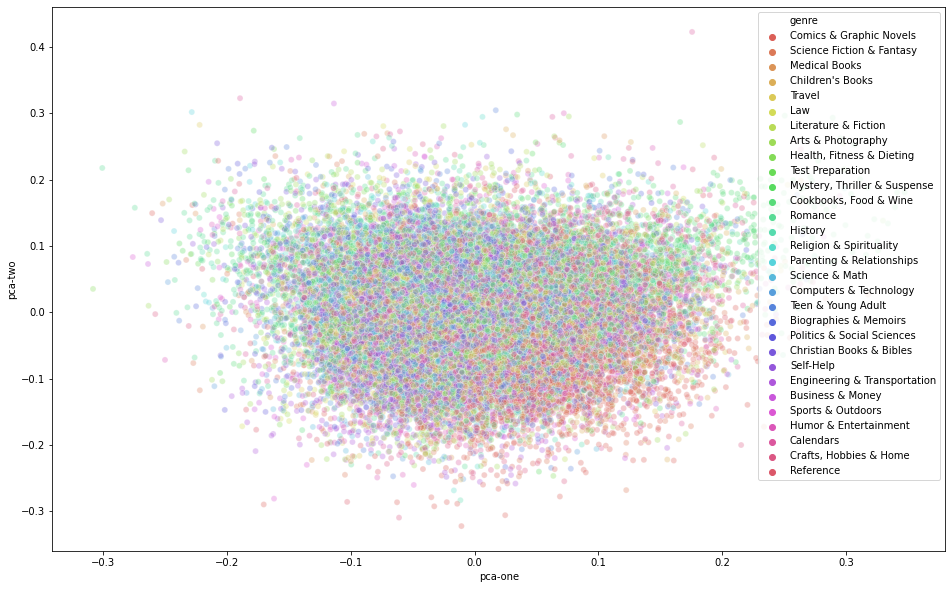

In [0]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="genre",
    palette=sns.color_palette("hls", 30),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

In [0]:
N = 15000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.02611652 0.02426196 0.02317376]


In [0]:
import time
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.098s...
[t-SNE] Computed neighbors for 15000 samples in 28.351s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for s

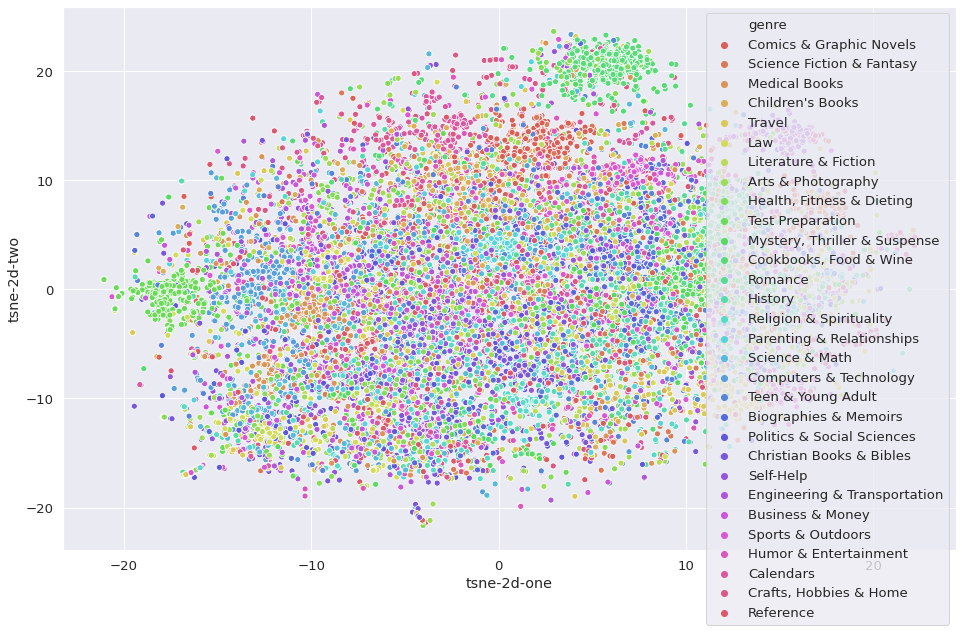

In [0]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="genre",
    palette=sns.color_palette("hls", 30),
    data=df_subset,
    legend="full",
    alpha=1
)

In [0]:
lda = LDA(n_components=3)
lda_result = lda.fit_transform(df[feat_cols].values, df.y)
df['lda-one'] = lda_result[:,0]
df['lda-two'] = lda_result[:,1] 
df['lda-three'] = lda_result[:,2]
print('Explained variation per principal component: {}'.format(lda.explained_variance_ratio_))

Explained variation per principal component: [0.2656928  0.19835904 0.13325938]


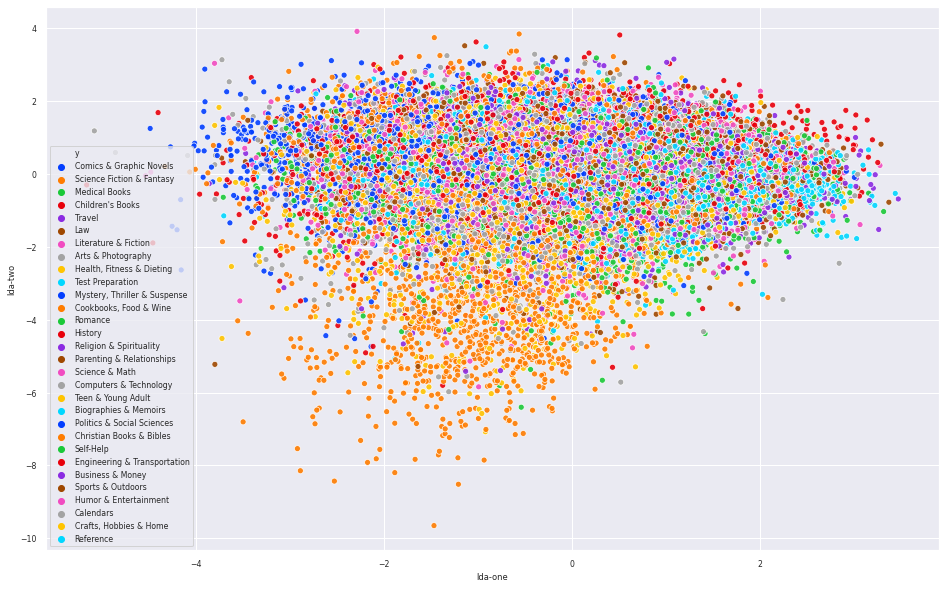

In [0]:
plt.figure(figsize=(16,10))
sns.set(font_scale=.7)
sns.scatterplot(
    x="lda-one", y="lda-two",
    hue="y",
    palette=sns.color_palette("bright", 30),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.9
)


In [0]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["lda-one"], 
    ys=df.loc[rndperm,:]["lda-two"], 
    zs=df.loc[rndperm,:]["lda-three"], 
    c=df.loc[rndperm,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('lda-one')
ax.set_ylabel('lda-two')
ax.set_zlabel('lda-three')
plt.show()

**Confusrion Matrix**

In [0]:
from sklearn.metrics import confusion_matrix
X1 = new_data[2][0]
X2 = new_data[2][1]
y = new_data[2][2]
X = np.concatenate((X1,X2),axis=1) 


In [0]:
y_pred = clf.predict(X)

In [0]:
conf_mat = confusion_matrix(y, y_pred)

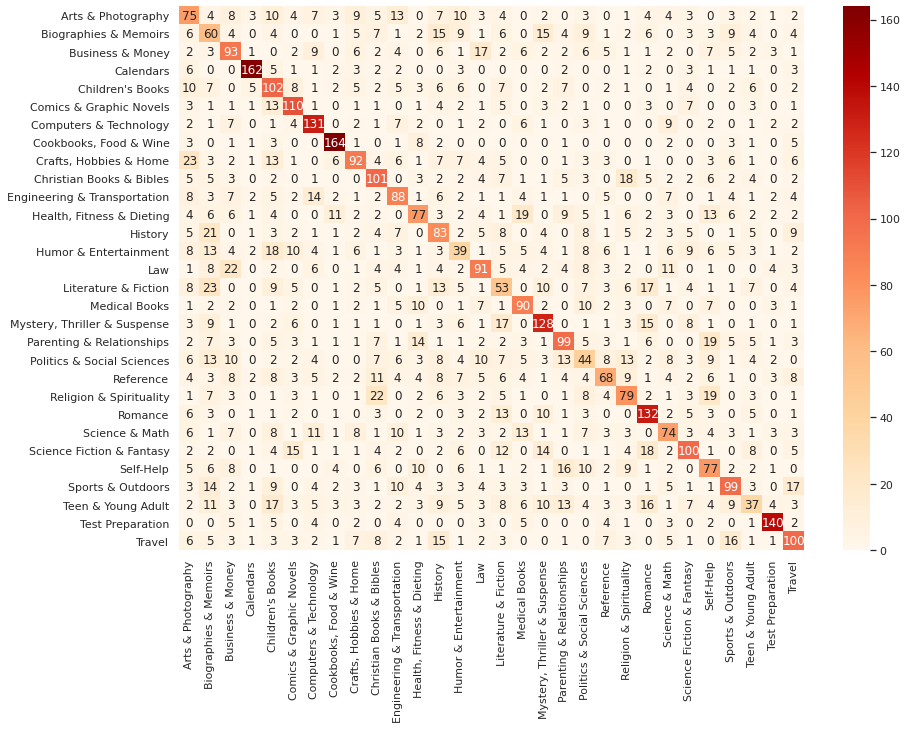

In [0]:
df_cm = pd.DataFrame(conf_mat, cat_dict.values(), cat_dict.values())
plt.figure(figsize=(14,10))
sns.set(font_scale=1) # for label size
sns.heatmap(df_cm, annot=True,fmt='d', annot_kws={"size": 12}, cmap="OrRd") # font size

plt.show()

In [0]:
for i in range(outdim_size):
  acc = df_cm.values[i,i]/sum(df_cm.iloc[i,:])
  print(df_cm.index[i], ": ",  str(acc*100), " %")

Arts & Photography :  39.473684210526315  %
Biographies & Memoirs :  33.14917127071823  %
Business & Money :  48.69109947643979  %
Calendars :  80.59701492537313  %
Children's Books :  52.04081632653062  %
Comics & Graphic Novels :  66.66666666666666  %
Computers & Technology :  69.68085106382979  %
Cookbooks, Food & Wine :  83.6734693877551  %
Crafts, Hobbies & Home :  46.231155778894475  %
Christian Books & Bibles :  54.3010752688172  %
Engineering & Transportation :  50.28571428571429  %
Health, Fitness & Dieting :  39.89637305699482  %
History :  44.148936170212764  %
Humor & Entertainment :  22.033898305084744  %
Law :  47.15025906735752  %
Literature & Fiction :  28.342245989304814  %
Medical Books :  55.90062111801242  %
Mystery, Thriller & Suspense :  60.66350710900474  %
Parenting & Relationships :  49.00990099009901  %
Politics & Social Sciences :  22.33502538071066  %
Reference :  34.51776649746193  %
Religion & Spirituality :  44.134078212290504  %
Romance :  66.33165829145